Chọn phương pháp biến đổi ảnh:
I - Image Inverse
G - Gamma Correction
L - Log Transformation
H - Histogram Equalization
C - Contrast Stretching
Đang xử lý ảnh: ha-long-bay-in-vietnam.jpg...


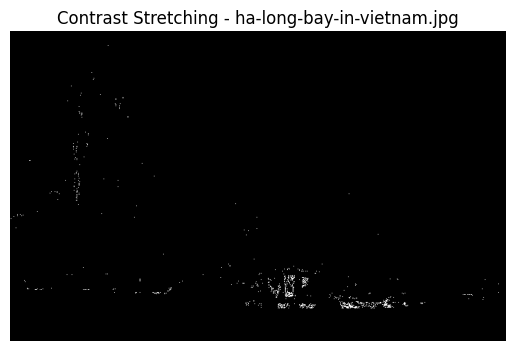

Đang xử lý ảnh: pagoda.jpg...


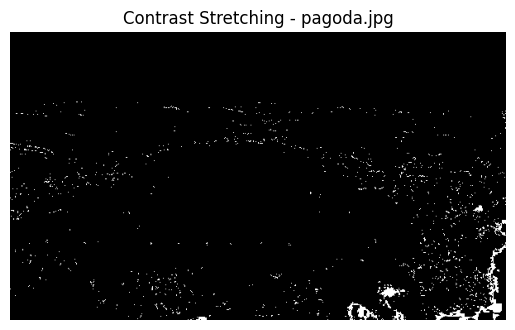

Đang xử lý ảnh: quang_ninh.jpg...


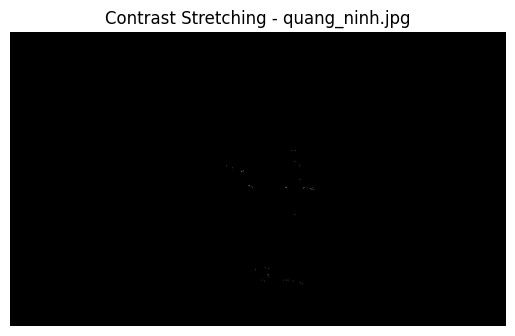

In [15]:
# Bài 1
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1. Các hàm xử lý ảnh (chỉ dùng PIL + numpy)
def inverse_image(img):
    return 255 - img

def gamma_correction(img, gamma=2.2):
    img = img / 255.0
    result = np.power(img, gamma)
    return np.uint8(result * 255)

def log_transformation(img):
    c = 255 / np.log(1 + np.max(img))
    result = c * np.log(1 + img)
    return np.uint8(result)

def histogram_equalization(img):
    # Tự viết hàm equalization (không dùng OpenCV)
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_norm = (cdf_masked - cdf_masked.min()) * 255 / (cdf_masked.max() - cdf_masked.min())
    cdf_final = np.ma.filled(cdf_norm, 0).astype('uint8')
    return cdf_final[img]

def contrast_stretching(img):
    a, b = np.min(img), np.max(img)
    stretched = 255 * (img - a) / (b - a)
    return np.uint8(stretched)

# 2. Bản đồ chọn hàm
methods = {
    'I': ('Inverse', inverse_image),
    'G': ('Gamma Correction', gamma_correction),
    'L': ('Log Transformation', log_transformation),
    'H': ('Histogram Equalization', histogram_equalization),
    'C': ('Contrast Stretching', contrast_stretching)
}

# 3. Hiển thị menu
print("Chọn phương pháp biến đổi ảnh:")
print("I - Image Inverse")
print("G - Gamma Correction")
print("L - Log Transformation")
print("H - Histogram Equalization")
print("C - Contrast Stretching")

choice = input("Nhập lựa chọn (I/G/L/H/C): ").upper()

if choice not in methods:
    print("Lựa chọn không hợp lệ.")
    exit()

method_name, method_function = methods[choice]

# 4. Đọc ảnh từ thư mục exercise/
input_folder = 'exercise'
output_folder = os.path.join(input_folder, 'output')
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.png')):
        input_path = os.path.join(input_folder, filename)
        print(f"Đang xử lý ảnh: {filename}...")

        # Mở ảnh xám
        img = Image.open(input_path).convert('L')
        img_np = np.array(img)

        # Áp dụng biến đổi
        if choice == 'G':
            result_np = method_function(img_np, gamma=2.2)
        else:
            result_np = method_function(img_np)

        # Lưu và hiển thị ảnh kết quả
        output_path = os.path.join(output_folder, f'{choice}_{filename}')
        Image.fromarray(result_np).save(output_path)

        plt.imshow(result_np, cmap='gray')
        plt.title(f"{method_name} - {filename}")
        plt.axis('off')
        plt.show()

In [17]:
import cv2
import numpy as np
import os

def fft_image(img):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    magnitude = 20 * np.log1p(np.abs(dft_shift))
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(magnitude)

def butterworth_lowpass(img, D0=30, n=2):
    rows, cols = img.shape
    V, U = np.meshgrid(np.arange(cols) - cols // 2, np.arange(rows) - rows // 2)
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (D / D0)**(2 * n))
    F = np.fft.fftshift(np.fft.fft2(img))
    G = H * F
    out = np.fft.ifft2(np.fft.ifftshift(G))
    return np.uint8(cv2.normalize(np.abs(out), None, 0, 255, cv2.NORM_MINMAX))

def butterworth_highpass(img, D0=30, n=2):
    low = butterworth_lowpass(img, D0, n)
    high = img.astype(np.float32) - low.astype(np.float32)
    return np.uint8(cv2.normalize(high, None, 0, 255, cv2.NORM_MINMAX))

key_map = {
    'F': ('fft', fft_image),
    'L': ('butter_lpf', butterworth_lowpass),
    'H': ('butter_hpf', butterworth_highpass)
}

key = input("Chọn phương pháp (F, L, H): ").upper()

if key in key_map:
    name, func = key_map[key]
    for file in os.listdir("exercise"):
        img = cv2.imread(f"exercise/{file}", cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        out = func(img)
        cv2.imwrite(f"exercise/{name}_{file}", out)
        cv2.imshow(name, out)
        if cv2.waitKey(0) == 27:
            break
    cv2.destroyAllWindows()
else:
    print("Phím không hợp lệ.")

In [18]:
import cv2
import numpy as np
import os
import random

def inverse(img): return 255 - img
def gamma_correction(img, gamma=2.2): return np.uint8(np.power(img / 255.0, 1/gamma) * 255)
def log_transform(img): return np.uint8(np.clip((255 / np.log(1 + np.max(img))) * np.log(1 + img.astype(np.float32)), 0, 255))
def histogram_equalization(img): return cv2.equalizeHist(img)
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    return np.uint8(np.clip((img - p2) * 255.0 / (p98 - p2), 0, 255))

def swap_rgb(img):
    return img[:, :, np.random.permutation(3)]

transform_funcs = [inverse, gamma_correction, log_transform, histogram_equalization, contrast_stretching]
names = ['inverse', 'gamma', 'log', 'hist', 'contrast']

for file in os.listdir("exercise"):
    img = cv2.imread(f"exercise/{file}")
    if img is None: continue

    swapped = swap_rgb(img)
    gray = cv2.cvtColor(swapped, cv2.COLOR_BGR2GRAY)
    
    idx = random.randint(0, 4)
    out = transform_funcs[idx](gray)
    name = names[idx]

    cv2.imwrite(f"exercise/random1_{name}_{file}", out)
    cv2.imshow(f"random1_{name}", out)
    if cv2.waitKey(0) == 27:
        break

cv2.destroyAllWindows()

In [19]:
import cv2
import numpy as np
import os
import random

def fft_image(img):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    magnitude = 20 * np.log1p(np.abs(dft_shift))
    return np.uint8(cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX))

def butterworth_lowpass(img, D0=30, n=2):
    rows, cols = img.shape
    V, U = np.meshgrid(np.arange(cols) - cols // 2, np.arange(rows) - rows // 2)
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (D / D0)**(2 * n))
    F = np.fft.fftshift(np.fft.fft2(img))
    G = H * F
    out = np.fft.ifft2(np.fft.ifftshift(G))
    return np.uint8(cv2.normalize(np.abs(out), None, 0, 255, cv2.NORM_MINMAX))

def butterworth_highpass(img, D0=30, n=2):
    low = butterworth_lowpass(img, D0, n)
    high = img.astype(np.float32) - low.astype(np.float32)
    return np.uint8(cv2.normalize(high, None, 0, 255, cv2.NORM_MINMAX))

def min_filter(img, ksize=3):
    return cv2.erode(img, np.ones((ksize, ksize), np.uint8))

def max_filter(img, ksize=3):
    return cv2.dilate(img, np.ones((ksize, ksize), np.uint8))

def swap_rgb(img):
    return img[:, :, np.random.permutation(3)]

funcs = [fft_image, butterworth_lowpass, butterworth_highpass]
names = ['fft', 'butter_lpf', 'butter_hpf']

for file in os.listdir("exercise"):
    img = cv2.imread(f"exercise/{file}")
    if img is None: continue

    swapped = swap_rgb(img)
    gray = cv2.cvtColor(swapped, cv2.COLOR_BGR2GRAY)

    idx = random.randint(0, 2)
    name = names[idx]
    out = funcs[idx](gray)

    if name == 'butter_lpf':
        out = min_filter(out)
    elif name == 'butter_hpf':
        out = max_filter(out)

    cv2.imwrite(f"exercise/random2_{name}_{file}", out)
    cv2.imshow(f"random2_{name}", out)
    if cv2.waitKey(0) == 27:
        break

cv2.destroyAllWindows()